In [1]:
from scipy.sparse import diags #linalg
from scipy.linalg import solve
import numpy as np

In [2]:
def solver(T,dt,QE):
    N = int(round(T/dt))
    t = np.linspace(0,T,N+1) #time discrete
    M = int(round(L/dx))
    x = np.linspace(0,L,M+1) #space discrete
    E = np.zeros((M+1,N+1))
    S = np.zeros((M+1,N+1))
    C = np.zeros((M+1,N+1))
    PPX = np.zeros((M+1))
    Em_E = np.zeros((M+1,N+1))
    B = np.zeros((M+1))
    RHS = np.zeros((M+1))
    E_lag = np.zeros((M+1,N+1))
    
    
    #initial conditions
    S[0,0] = 1
    C[0,0] = 0.8
    E[0,0] = p*den*h*S[0,0]+p*h*den*theta*C[0,0]
    B[0] = Q*S[0,0]/(A1[0, 0])-(K*A*((Em_E[1,0]-Em_E[0,0])/dx)*E[0,0])/(A1[0, 0])  #boundary condition
    Em_E[0:M+1,0] = 0.55556
    
    #lagrangian Step
    E_lag[0,0] = E[0,0]
    E_lag[1:M+1,0] = E[1:M+1,0]+0.2*(dt/dx)*(E[0:M,0]-E[1:M+1,0])
    
    #special time step at n=0
    U = diags([1], [0,], shape=(M+1, M+1)).toarray()
    #QE = np.multiply(QE,Em_E[0:M+1,0])
    PPX[:] = np.dot(QP, Em_E[0:M+1,0])
    PPX[PPX<0]=0 
    M1 = U / dt + QE #+ np.multiply(U*Q,PPX[:]) - np.multiply(Q2,PPX[:])
    M2 = U / dt 
    RHS[:] = M2.dot(E_lag[0:M+1,0]) + B
    E[:,1] = np.linalg.solve(M1, RHS)
    S[:,1] = E[:,1] / (den*p*h+0.8*p*h*den*theta)
    C[:,1] = 0.8 * S[:,1]
    

    for n in range(1,N):
        Em_E[0:M+1,n] = np.divide(E[0:M+1,n]-p*h*den*theta*C[0:M+1,n], E[0:M+1,n],out=np.zeros_like(E[0:M+1,n]-p*h*den*theta*C[0:M+1,n]), where=E[0:M+1,n]!=0)
        E_lag[1:M+1,n] = E[1:M+1,n]+0.2*(dt/dx)*(E[0:M,n]-E[1:M+1,n])
        E_lag[0,n] = E[0,n]
        U = diags([1], [0,], shape=(M+1, M+1)).toarray()
        #QE = np.multiply(QE,Em_E[0:M+1,n])
        PPX[:] = np.dot(QP, Em_E[0:M+1,n])
        PPX[PPX<0]=0
        M1 = U / dt + QE # + np.multiply(U*Q,PPX[:]) - np.multiply(Q2,PPX[:])
        M2 = U / dt
        B[0] = (-Q*S[0,n] + Q*S[0,0])/(A1[0, 0])-(K*A*((Em_E[1,n]-Em_E[0,n])/dx)*E[0,n])/(A1[0, 0]) #boundary condition 
        RHS[:] = M2.dot(E_lag[0:M+1,n]) + B
        E[:,n+1] = np.linalg.solve(M1, RHS)
        S[:,n+1] = E[:,n+1] / (den*p*h+0.8*p*h*den*theta)
        C[:,n+1] = 0.8 * S[:,n+1]
        
        
    return   S, x, t


In [15]:
from scipy.integrate import quad
#Solving for matrices L1, L2, L3
T = 1800
L = 50000
wd = 10         #width
h = 5           #height
fv = 0.4        #flow velocity
sg = 1          #specific gravity
den = 0.01       #density of CIMW and CMW
p = 2*h+wd      #wetted perimeter
theta = 1       #porosity
l = 50          #element distance
Q = 20          #flow rate
#K = 1.25 #Case1          #dispersion coefficient K=diffusion+dispersitivity*fv
K = 25 #Case2
#K = 400 #Case3
A = 50          #Area
dt = 180         #time step size
dx = 50
w1 = 1          #weight
w2 = 0
xi = 42.8
f = 14.4
N = int(round(T/dt))          #no. of time steps
M = int(round(L/dx))          #no. of nodes


#Solving for A1
def integrand(x):
    return (1-x/l)*A*(1-x/l)
ans1, err = quad(integrand, 0, l)

def integrand(x):
    return (1-x/l)*A*(x/l)
ans2, err = quad(integrand, 0, l)

def integrand(x):
    return (x/l)*A*(1-x/l)
ans3, err = quad(integrand, 0, l)

def integrand(x):
    return (x/l)*A*(x/l)
ans4, err = quad(integrand, 0, l)

A1 = diags([ans3 + ans1 + ans4 + ans2], [0], shape=(M+1, M+1)).toarray()
A1[0, 0] = ans1 + ans2
A1[M, M] = ans3 + ans4 


#Solving for A2
def integrand(x):
    return (-1/l)*0.5*K*A*(-1/l)
ans5, err = quad(integrand, 0, l)

def integrand(x):
    return (-1/l)*0.5*K*A*(1/l)
ans6, err = quad(integrand, 0, l)

def integrand(x):
    return (1/l)*0.5*K*A*(-1/l)
ans7, err = quad(integrand, 0, l)

def integrand(x):
    return (1/l)*0.5*K*A*(1/l)
ans8, err = quad(integrand, 0, l)

A2 = diags([ans7,(ans5+ans8),ans6], [-1,0,1], shape=(M+1, M+1)).toarray()
A2[0, 0] = ans5
A2[M, M] = ans8

#Solving for QE
QE = A2 / (ans3 + ans1 + ans4 + ans2)
QE[0,0] = A2[0,0] / (ans1 + ans2)
QE[0,1] = A2[0,1] / (ans1 + ans2)
QE[M,M-1] = A2[M,M-1] / (ans3 + ans4)
QE[M,M] = A2[M,M] / (ans3 + ans4)


#Solving QP1

def integrand(x):
    return (1-x/l)*(1-x/l)
ans9, err = quad(integrand, 0, l)

def integrand(x):
    return (1-x/l)*(x/l)
ans10, err = quad(integrand, 0, l)

def integrand(x):
    return (x/l)*(x/l)
ans11, err = quad(integrand, 0, l)

QP1_11 = ans9
QP1_12 = ans10
QP1_21 = ans10
QP1_22 = ans11

#QP1 Lump Matrix
QP1 = diags([ans9+2*ans10+ans11],[0], shape=(M+1, M+1)).toarray()
QP1[0,0] = ans9+ans10
QP1[M,M] = ans10+ans11

#Solving for QP2

def integrand(x):
    return (1-x/l)*(-1/l)
ans12, err = quad(integrand, 0, l)

def integrand(x):
    return (1-x/l)*(1/l)
ans13, err = quad(integrand, 0, l)

def integrand(x):
    return (x/l)*(-1/l)
ans14, err = quad(integrand, 0, l)

def integrand(x):
    return (x/l)*(1/l)
ans15, err = quad(integrand, 0, l)

QP2_11 = ans12
QP2_12 = ans13
QP2_21 = ans14
QP2_22 = ans15

QP2 = diags([ans14,(ans12+ans15),ans13], [-1,0,1], shape=(M+1, M+1)).toarray()
QP2[0, 0] = ans12
QP2[M, M] = ans15

#matrix QP
QP = QP2/ (ans9+2*ans10+ans11)
QP[0,0] = QP2[0,0]/(ans9+ans10)
QP[0,1] = QP2[0,1]/(ans9+ans10)
QP[M,M-1] = QP2[M,M-1]/(ans11+ans10)
QP[M,M] = QP2[M,M]/(ans11+ans10)

Q2 = np.zeros((M+1,M+1)) #A*K*diags([ans13,(ans12+ans15),ans14],[-1,0,1],shape=(M+1, M+1)).toarray() 
Q2[0,0] = A*K*(ans14)
Q2[M,M] = A*K*(ans13)

(S,x,t) = solver(T,dt,QE)



In [8]:
from matplotlib import pyplot as plt

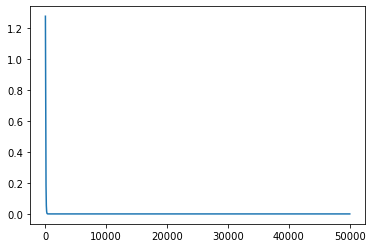

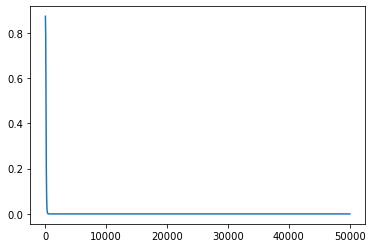

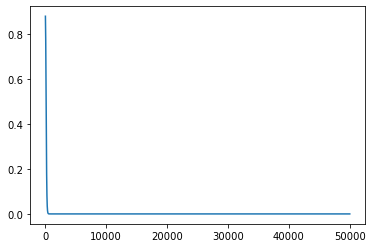

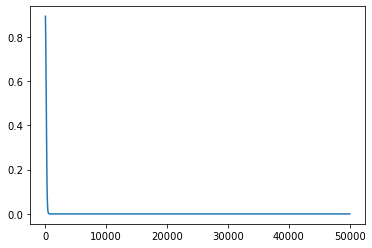

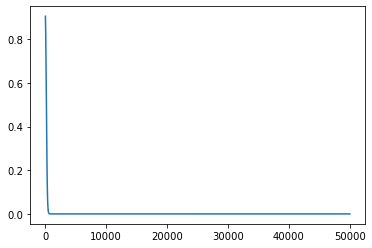

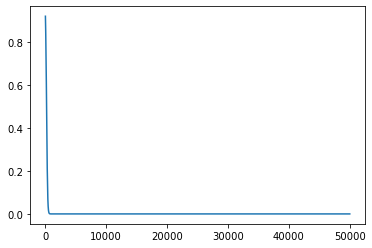

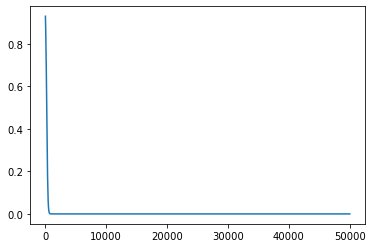

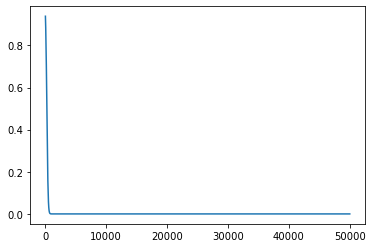

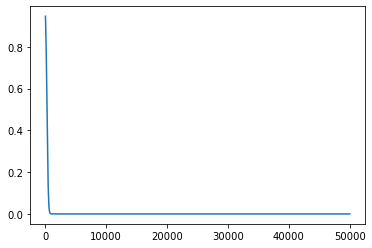

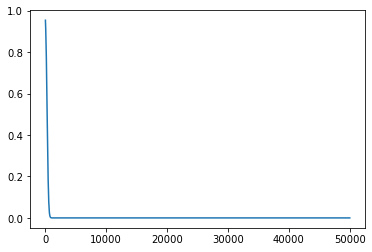

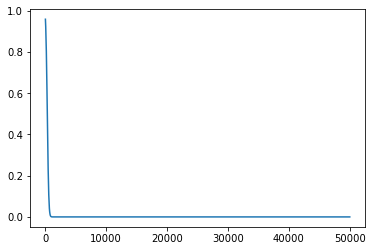

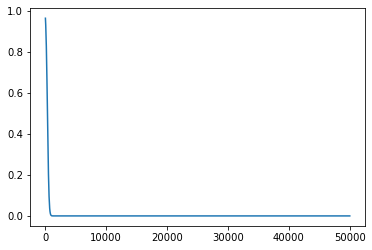

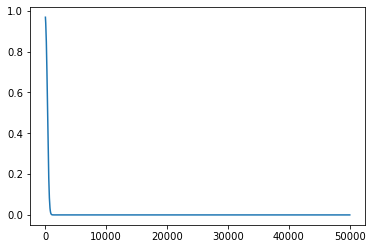

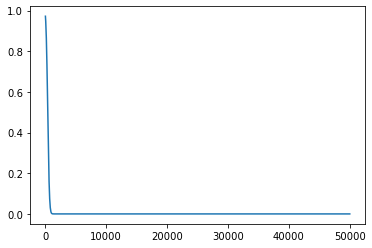

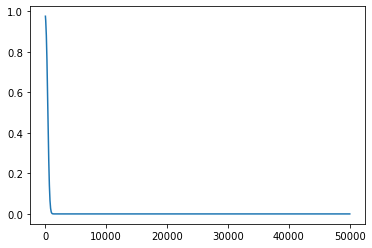

IndexError: index 16 is out of bounds for axis 1 with size 16

In [32]:
t = np.linspace(0,T,N+1)
for n in range(len(t)):
    plt.plot(x,S[:,n+1])
    plt.show()

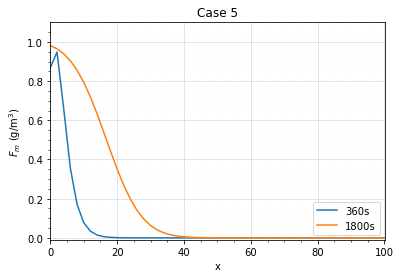

In [16]:
fig, ax = plt.subplots()
ax.axis([-0.1,100+0.1,-0.01,1.1]) 
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

plt.plot(x/25,S[:,2])
plt.plot(x/25,S[:,N])
plt.legend(["360s", "1800s"], loc ="lower right")
plt.xlabel("x")
plt.ylabel("$F_m$ (g/m$^3$)")
plt.title("Case 5")
plt.savefig('Example 1 Option 3 Case 5.png')

plt.show()

In [182]:
from matplotlib import animation as animation
from IPython.display import HTML

In [183]:
#fig = plt.figure()
fig, ax = plt.subplots()
ax.axis([-0.1,100+0.1,-0.01,1.1]) 
ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.minorticks_on()

plt.rcParams['figure.figsize'] = (5,3)
plt.rcParams["animation.html"] = "jshtml"  # for matplotlib 2.1 and above, uses JavaScript

def initpict():
    x = np.linspace(0, L, M+1)
    line.set_data(x/25,S[:,0])

line, = plt.plot([ ], [ ], lw=3) 

def redraw(i):
    x = np.linspace(0, L, M+1)
    line.set_data(x/25, S[:,i])

anim = animation.FuncAnimation(fig, redraw, init_func=initpict, frames=len(t), interval=100)
fig.suptitle('Example 1  Option 3', fontsize=14)

plt.close()
anim

In [90]:
A = [[1,2,3],
    [2,3,4]]
B = [1,2,3]
C = np.multiply(A,B)
print(C)

[[ 1  4  9]
 [ 2  6 12]]
